In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats import weightstats as stests

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/CS/CS1951A/poker_updated.db"
conn = sqlite3.connect(path)
c = conn.cursor()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
get_history = ''' 
    SELECT game_id, player_id, net_gain FROM Hands
    ORDER BY player_id ASC, game_id ASC;
'''
get_players = '''
    SELECT DISTINCT player_id FROM HANDS
    ORDER BY player_id ASC;
'''
history = pd.read_sql_query(get_history, conn).values
players = pd.read_sql_query(get_players, conn)
print(history)
print(players)

[['20161229165011' '!MushroomMan!' -0.5]
 ['20161229165348' '!MushroomMan!' 0.25]
 ['20161229165420' '!MushroomMan!' -0.25]
 ...
 ['20161209235346' 'zzXzz' -0.5]
 ['20161209235412' 'zzXzz' 0.0]
 ['20161209235454' 'zzXzz' 0.0]]
          player_ID
0     !MushroomMan!
1              ....
2             00MOD
3          01001111
4        0nlyDaNuts
...             ...
2392       zimsaw55
2393       zionnoiz
2394      zitkojosh
2395         zqzqzq
2396          zzXzz

[2397 rows x 1 columns]


In [16]:
player_num = -1

# for each player
total_post_win = 0
total_post_loss = 0
win_post_win = 0
win_post_loss = 0

player_wpw = [] #list of tuples (player, pct_wpw)
player_wpl = [] #list of tuples (player, pct_wpl)

for i in range(1, len(history)):

  prev_player = history[i-1][1]
  prev_net_gain = history[i-1][2]
  cur_player = history[i][1]
  cur_net_gain = history[i][2]

  # end of database
  if (i == len(history) - 1):
    if (total_post_win > 0):
      pct_wpw = win_post_win/total_post_win
      player_wpw.append((player_num + 1, pct_wpw))
    if (total_post_loss > 0):
      pct_wpl = win_post_loss/total_post_loss
      player_wpl.append((player_num + 1, pct_wpl))

  # given player plays multiple hands
  elif (cur_player == prev_player):
    if (prev_net_gain > 0) and (cur_net_gain != 0):
      total_post_win += 1
      if (cur_net_gain > 0):
        win_post_win += 1
    elif (prev_net_gain < 0) and (cur_net_gain != 0):
      total_post_loss += 1
      if (cur_net_gain > 0):
        win_post_loss += 1
  # change players
  else:
    player_num += 1
    if (total_post_win > 0):
      pct_wpw = win_post_win/total_post_win
      player_wpw.append((player_num, pct_wpw))
    if (total_post_loss > 0):
      pct_wpl = win_post_loss/total_post_loss
      player_wpl.append((player_num, pct_wpl))
    win_post_win = 0
    win_post_loss = 0
    total_post_win = 0
    total_post_loss = 0
  
player_wpw = np.array(player_wpw)
player_wpl = np.array(player_wpl)
print('wpw data: \n', player_wpw)
print('wpl data: \n', player_wpl)

wpw data: 
 [[0.00000000e+00 2.50000000e-01]
 [1.00000000e+00 1.66666667e-01]
 [2.00000000e+00 5.00000000e-01]
 ...
 [2.39300000e+03 5.14285714e-01]
 [2.39400000e+03 3.84615385e-01]
 [2.39600000e+03 4.00000000e-01]]
wpl data: 
 [[0.00000000e+00 6.25000000e-01]
 [1.00000000e+00 3.88888889e-01]
 [2.00000000e+00 5.00000000e-01]
 ...
 [2.39300000e+03 5.93750000e-01]
 [2.39400000e+03 4.28571429e-01]
 [2.39600000e+03 4.37500000e-01]]


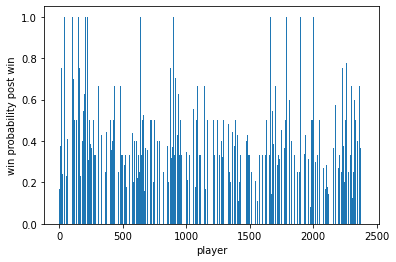

average win probability post win:  0.3108801764989244


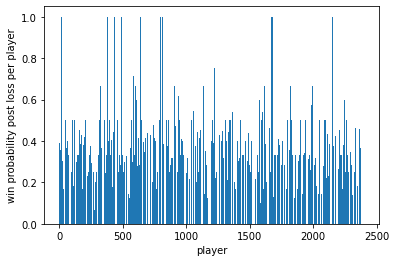

average win probability post loss per player:  0.33622444510270727


In [17]:
# assuming all players are equal level
avg_wpw_prob = np.average(player_wpw[:, 1])
avg_wpl_prob = np.average(player_wpl[:, 1])

wpw_x = list(player_wpw[:, 0])
wpw_y = list(player_wpw[:, 1])
plt.bar(wpw_x, wpw_y, width=1)
plt.ylabel('win probability post win')
plt.xlabel('player')
plt.show()
print("average win probability post win: ", avg_wpw_prob)

wpl_x = list(player_wpl[:, 0])
wpl_y = list(player_wpl[:, 1])
plt.bar(wpl_x, wpl_y, width=1)
plt.ylabel('win probability post loss per player')
plt.xlabel('player')
plt.show()
print("average win probability post loss per player: ", avg_wpl_prob)

In [19]:
#testing H0: # P(winning a hand | player won last session) = P(winning a hand | player lost last session)

tstat, pval, dof = stests.ttest_ind(wpw_y, wpl_y, usevar='unequal')
print("p-value: ", pval)

p-value:  0.0015168949645322754
